### Attention of TanhMax(IMDB)

In [1]:
import pandas as pd
import torch.utils.data as Data
import torch.optim as optim
from torch.autograd import Variable
import torch
import pickle
from torch import optim
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
filename = 'data/local_dict.pkl'
path = filename
dict_file = open(path, 'rb')

vocab  = pickle.load(dict_file)[0]
print('length of vocabulary: ',len(vocab))
dict_file.close()

filename = "data/Train.csv"
Train = pd.read_csv(filename)

length of vocabulary:  16174


In [3]:
vocab_size = 8000
text_length = 30
batch_size = 100
epoch_num = 100

word2idx = {'[PAD]':0}
for i, w in enumerate(vocab[:vocab_size]):
    word2idx[w] = i + 1
idx2word = {i: w for i, w in enumerate(word2idx)}

doc_list = Train['text'].to_list()
temp = Train['label'].astype('int').to_list()
labels = list()
for i in range(len(temp)):
    if temp[i] == 0:
        labels.append(0.)
    else:
        labels.append(1.)

In [4]:
from model import make_data
data = make_data(doc_list,word2idx,text_length)

In [5]:
len(data),len(labels)

(40000, 40000)

In [6]:
from model import MyDataSet

batch = Variable(torch.LongTensor(data))
labels = Variable(torch.LongTensor(labels))
loader = Data.DataLoader(MyDataSet(batch,labels), batch_size, True)

In [7]:
#from model import SelfAttnClassifier
def TanhMax(a):
    return (torch.exp(a) - torch.exp(-a)) / (torch.exp(a) + torch.exp(-a)).sum(dim=-1).unsqueeze(dim=-1)
    
class SelfAttnClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim=1, scale=1,score_function='dot', activation='TanhMax'):
        super(SelfAttnClassifier, self).__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.embeddings.weight.data.uniform_(-0.1, 0.1)
        self.scale = scale
        self.Wk = nn.Linear(embed_dim,hidden_dim)
        self.Wv = nn.Linear(embed_dim,hidden_dim)
        self.Wq = nn.Linear(embed_dim,hidden_dim)
        self.score_function = score_function
        if self.score_function == 'additive':
            self.v = nn.Parameter(torch.randn(hidden_dim, 1))
        
        if activation.lower() == 'softmax':
            self.activate = nn.Softmax(dim=-1)
        elif activation.lower() == 'tanhmax':
            self.activate = TanhMax
        elif activation.lower() == 'tanh':
            self.activate = nn.Tanh()
        
        self.dropout = nn.Dropout(0.5)
        self.dense = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        

    # batch_size * sent_l * dim
    def forward(self, seq_ids, labels=None):
        seq_embs = self.embeddings(seq_ids)
        
        Q = self.Wq(seq_embs)
        K = self.Wk(seq_embs)
        V = self.Wv(seq_embs)
        
        if self.score_function == 'dot':
            scores = (Q*K).sum(dim=-1) / self.scale
        elif self.score_function == 'additive':
            scores = torch.matmul(nn.Tanh(K+Q),self.v)
            
        if labels is None:
            scores = scores 
        else:
            scores = scores * labels.unsqueeze(dim=-1)
            
        attn = self.activate(scores)
        final_vec = torch.bmm(attn.unsqueeze(1), V).squeeze(1)
        senti_scores = self.dense(self.dropout(final_vec))
        probs = self.sigmoid(senti_scores)
        return probs

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

loss_function = nn.BCELoss()
model = SelfAttnClassifier(vocab_size+1, 200, 100, 1, scale=5.0, score_function='dot',activation='TanhMax')
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.05)

use_gpu = torch.cuda.is_available()

if(use_gpu):
    model = model.cuda()
    loss_function = loss_function.cuda()

In [8]:
model.train()
for epoch in tqdm(range(100)):
    for input_ids, label in loader:
        model.zero_grad()
        preds = model(input_ids.cuda())
        loss = loss_function(preds.squeeze(), label.cuda().float()) * 100
        loss.backward(retain_graph=True)
        optimizer.step()
        input_ids.cpu()
        label.cpu()

100%|██████████| 100/100 [06:28<00:00,  3.88s/it]


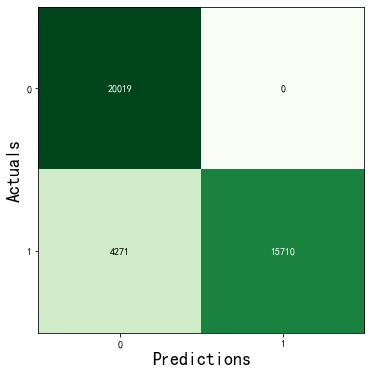

accuracy:89.323%


In [9]:
from model import plot_cm_matrix
plot_cm_matrix(model,batch,labels,save_url='graph/metric/TanhMaxTrainAcc.png')

### test accuracy

In [10]:
filename = "data/Test.csv"
Test = pd.read_csv(filename)

doc_list = Test['text'].to_list()
test_labels = Test['label'].astype('int').to_list()
    
test_data = make_data(doc_list,word2idx,text_length)
len(test_data),len(test_labels)

(5000, 5000)

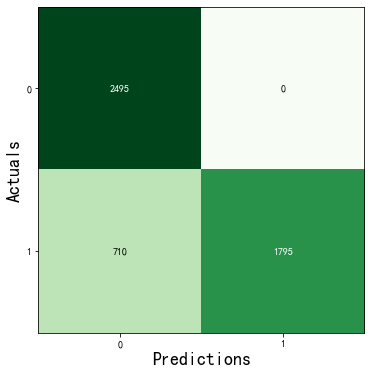

accuracy:85.800%


In [11]:
test_batch = Variable(torch.LongTensor(test_data))
test_labels = Variable(torch.LongTensor(test_labels))
plot_cm_matrix(model,test_batch,test_labels,save_url='graph/metric/picture6.png')

### Save Model

In [12]:
## 保存
torch.save(model.state_dict(), 'model/TanhMaxParameter.pkl')
torch.save(model, 'model/TanhMaxModel.pkl')

## 加载
#model = SelfAttnClassifier(vocab_size+1, 30, 10, 1, scale=5.0,score_function='dot',activation='SoftMax')
#model.load_state_dict(torch.load('model/SoftmaxParameter.pkl'))

# 加载
#model = torch.load('model/SoftmaxModel.pkl')

### Select Tokens

In [13]:
from model import SelectTokens
Pos,Neg,Neu = SelectTokens(data,labels,word2idx)

### Visualization

In [14]:
#from model import compute_coefficients
pos_index,pos_score,pos_weight,neg_index,neg_score,neg_weight,neutral_index,neutral_score,neutral_weight = compute_coefficients(model,batch,Pos,Neg,Neu,word2idx)

Pos Mean: 2.16763826705314 Pos Std: 0.690458030389664
Neg Mean: -0.9459877325087722 Neg Std: 0.5711515074044641
Neu Mean: -0.10194792659355263 Neu Std: 0.4235981839606084


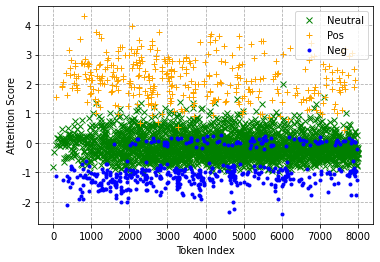

In [15]:
plt.rcParams['axes.unicode_minus'] = False
plt.plot(neutral_index, neutral_score, 'x', label='Neutral',color='green')
plt.plot(pos_index, pos_score, '+',label='Pos',color='orange')
plt.plot(neg_index, neg_score, '.', label='Neg',color='blue')
plt.xlabel('Token Index')
plt.ylabel('Attention Score')
plt.grid(linestyle='--')
plt.legend()
plt.savefig('graph/metric/picture4.png')
print('Pos Mean:',np.mean(pos_score),'Pos Std:',np.std(pos_score))
print('Neg Mean:',np.mean(neg_score),'Neg Std:',np.std(neg_score))
print('Neu Mean:',np.mean(neutral_score),'Neu Std:',np.std(neutral_score))

Pos Mean: 0.1275179777595479 Pos Std: 0.07973591763811076
Neg Mean: -0.035904681544180424 Neg Std: 0.02462950800975233
Neu Mean: -0.0029996231620482905 Neu Std: 0.01345337897058345


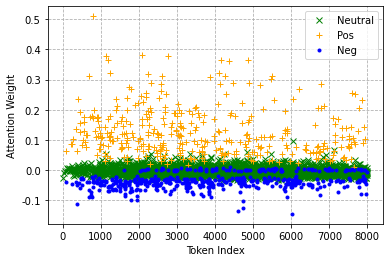

In [16]:
plt.rcParams['axes.unicode_minus'] = False
plt.plot(neutral_index, neutral_weight, 'x', label='Neutral',color='green')
plt.plot(pos_index, pos_weight, '+',label='Pos',color='orange')
plt.plot(neg_index, neg_weight, '.', label='Neg',color='blue')
plt.xlabel('Token Index')
plt.ylabel('Attention Weight')
plt.grid(linestyle='--')
plt.legend()
plt.savefig('graph/metric/picture5.png')
print('Pos Mean:',np.mean(pos_weight),'Pos Std:',np.std(pos_weight))
print('Neg Mean:',np.mean(neg_weight),'Neg Std:',np.std(neg_weight))
print('Neu Mean:',np.mean(neutral_weight),'Neu Std:',np.std(neutral_weight))

### Exp1 -- Gradient Importance

5000it [00:09, 511.02it/s]


Both label
	p-value < 0.05: 2417  ratio: 0.4834
	p-value < 0.01: 1666  ratio: 0.3332
	Both-Mean: -0.22485387934408504 Std: 0.22346154318540049

Pos
	p-value < 0.05: 1614  ratio: 0.644311377245509
	p-value < 0.01: 1224  ratio: 0.48862275449101794
	Pos-Mean: -0.32266520753932726 Std: 0.18661705032337358

Neg
	p-value < 0.05: 803  ratio: 0.3218436873747495
	p-value < 0.01: 442  ratio: 0.17715430861723447
	Neg-Mean: -0.12665052177731875 Std: 0.214138871965273


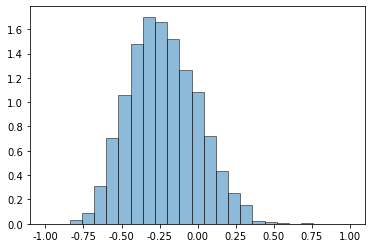

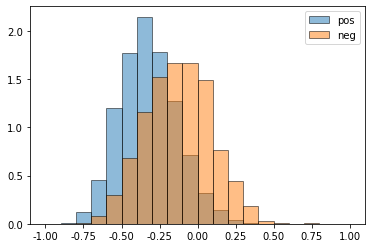

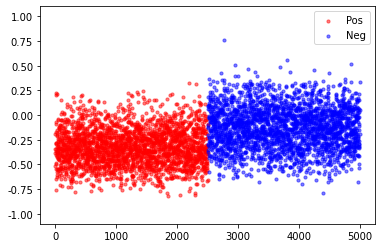

In [17]:
from model import GradientImportance
GradientImportance(model,test_batch,test_labels,'TanhMax')

### Exp2--Feature Erasure

5000it [00:56, 88.36it/s] 


Both label
	p-value < 0.05: 5000  ratio: 1.0
	p-value < 0.01: 5000  ratio: 1.0
	total num: 5000  mean: 0.9792748615584973  std: 0.014805866300879718
Pos
	p-value < 0.05: 2505  ratio: 1.0
	p-value < 0.01: 2505  ratio: 1.0
	total num: 2505  mean: 0.9791991518766042  std: 0.014855751959038621
Neg
	p-value < 0.05: 2495  ratio: 1.0
	p-value < 0.01: 2495  ratio: 1.0
	total num: 2495  mean: 0.979350874686009  std: 0.014755220229690938


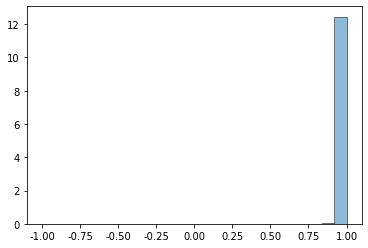

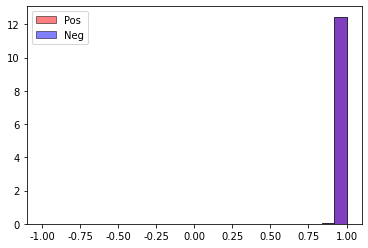

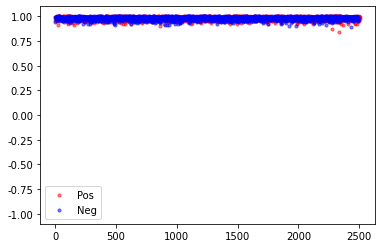

In [18]:
from model import FeatureErasure
FeatureErasure(model,test_batch,test_labels,'TanhMax')

### Exp3--Feature Erasure ABS

5000it [00:59, 83.94it/s]


Both label
	p-value < 0.05: 5000  ratio: 1.0
	p-value < 0.01: 5000  ratio: 1.0
	total num: 5000  mean: 0.9493065986609185  std: 0.023728146039266762
Pos
	p-value < 0.05: 2505  ratio: 1.0
	p-value < 0.01: 2505  ratio: 1.0
	total num: 2505  mean: 0.953122100202732  std: 0.02299442115316049
Neg
	p-value < 0.05: 2495  ratio: 1.0
	p-value < 0.01: 2495  ratio: 1.0
	total num: 2495  mean: 0.9454758045277549  std: 0.02383594850186049


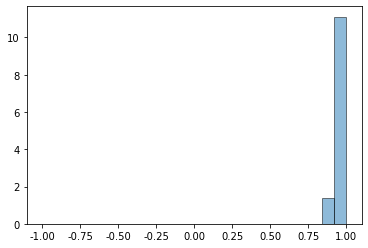

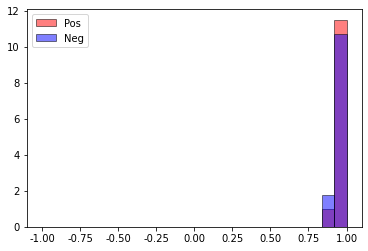

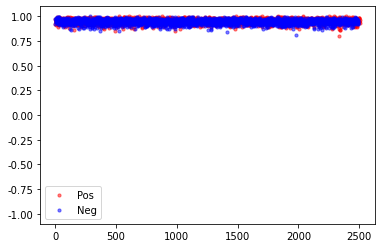

In [19]:
from model import FeatureErasureABS
FeatureErasureABS(model,test_batch,test_labels,'TanhMax')

### Exp4--Attention Permutation

5000it [03:21, 24.76it/s]


Both label
	total num: 5000  mean: 0.16798761  std: 0.125555
Pos
	total num: 2505  mean: 0.15266699  std: 0.11203625
Neg
	total num: 2495  mean: 0.18336965  std: 0.13607569


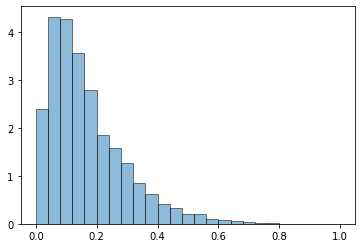

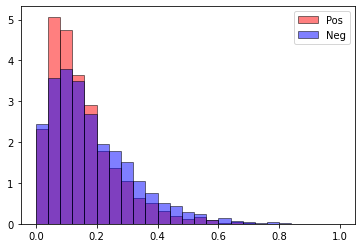

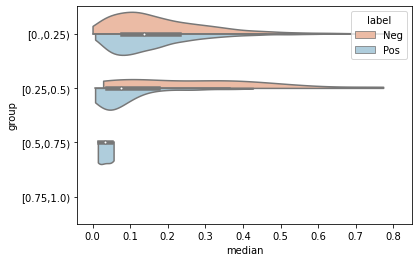

                  median                                                    \
                   count      mean       std       min       25%       50%   
label group                                                                  
Neg   [0.,0.25)   2457.0  0.182092  0.134581  0.000017  0.082799  0.148962   
      [0.25,0.5)    38.0  0.265975  0.198138  0.028207  0.090209  0.272106   
Pos   [0.,0.25)   2407.0  0.155475  0.112123  0.006882  0.073175  0.126798   
      [0.25,0.5)    94.0  0.085824  0.086704  0.006809  0.034221  0.053836   
      [0.5,0.75)     4.0  0.033784  0.020188  0.014151  0.018111  0.032514   

                                      
                       75%       max  
label group                           
Neg   [0.,0.25)   0.252046  0.809317  
      [0.25,0.5)  0.392545  0.772814  
Pos   [0.,0.25)   0.207293  0.706705  
      [0.25,0.5)  0.100334  0.426550  
      [0.5,0.75)  0.048188  0.055958  


In [20]:
from model import AttnPermutation
AttnPermutation(model,test_batch,test_labels,'TanhMax')

### Exp5--Attention Randomization

5000it [04:14, 19.65it/s]


Both label
	total num: 5000  mean: 0.47680995  std: 0.28258502
Pos
	total num: 2505  mean: 0.47555435  std: 0.27071124
Neg
	total num: 2495  mean: 0.4780706  std: 0.294019


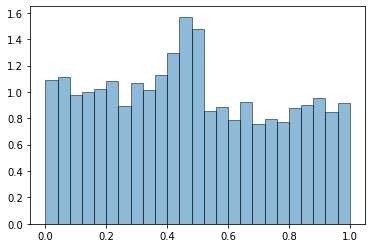

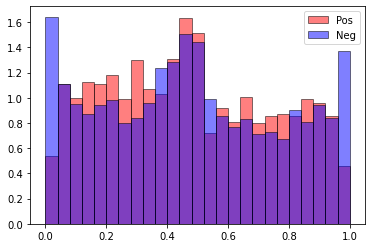

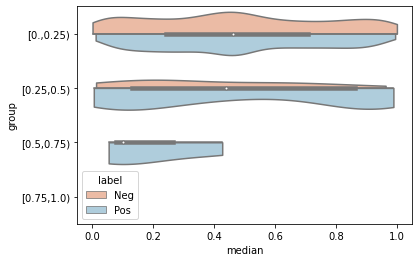

                  median                                                    \
                   count      mean       std       min       25%       50%   
label group                                                                  
Neg   [0.,0.25)   2475.0  0.478773  0.294105  0.000276  0.231780  0.464521   
      [0.25,0.5)    20.0  0.391163  0.284562  0.011872  0.182959  0.287631   
Pos   [0.,0.25)   2449.0  0.475514  0.267813  0.010464  0.248798  0.459663   
      [0.25,0.5)    53.0  0.493363  0.383821  0.004366  0.095320  0.459656   
      [0.5,0.75)     3.0  0.193542  0.202792  0.053187  0.077289  0.101392   

                                      
                       75%       max  
label group                           
Neg   [0.,0.25)   0.721252  0.999671  
      [0.25,0.5)  0.632191  0.962515  
Pos   [0.,0.25)   0.699652  0.993815  
      [0.25,0.5)  0.911036  0.988140  
      [0.5,0.75)  0.263719  0.426046  


In [28]:
from model import AttnRandom
AttnRandom(model,test_batch,test_labels,'TanhMax')

### check selected tokens

In [29]:
pos_df = pd.DataFrame(zip(pos_index,pos_score),columns=['index','value'])
pos_top_index = pos_df.sort_values(by='value',ascending=False)['index'].values[:50]
pos_top_words = []
for item in pos_top_index:
    pos_top_words.append(idx2word[item])
print(pos_top_words)
print(len(pos_df))

['coping', 'bogus', 'divine', 'finely', 'nonstop', 'delicate', 'canon', 'stalker', 'charged', 'ambiguous', 'stroke', 'profoundly', 'fragile', 'poetry', 'existential', 'bread', 'zany', 'clint', 'iris', 'lighthearted', 'entranced', 'quietly', 'occurs', 'abroad', 'backed', 'lengths', 'definitive', 'achievements', 'vital', 'insanity', 'personalities', 'labor', 'vera', 'engrossing', 'marvelous', 'diary', 'rewarded', 'imaginative', 'chiller', 'psyche', 'ages', 'bittersweet', 'dogma', 'breathtaking', 'reflects', 'bike', 'harrowing', 'niche', 'marvelously', 'goodfellas']
370


In [30]:
neg_df = pd.DataFrame(zip(neg_index,neg_score),columns=['index','value'])
neg_top_index = neg_df.sort_values(by='value',ascending=True)['index'].values[:50]
neg_top_words = []
for item in neg_top_index:
    neg_top_words.append(idx2word[item])
print(neg_top_words)
print(len(neg_df))

['novak', 'miyazaki', 'enchanting', 'election', 'rouge', 'devito', 'witherspoon', 'hugh', 'transcends', 'brooding', 'loneliness', 'shout', 'dogtown', 'enduring', 'richness', 'realization', 'nuanced', 'emerge', 'introspective', 'fills', 'formed', 'visionary', 'kieslowski', 'splendidly', 'introducing', 'cynicism', 'realistically', 'benefits', 'layered', 'spellbinding', 'lovingly', 'heal', 'rewarding', 'escapism', 'sensationalism', 'relaxed', 'escapist', 'shoulders', 'maguire', 'bewitched', 'traces', 'detract', 'frailty', 'underestimated', 'pow', 'alternately', 'turbulent', 'capra', 'fluid', 'pre']
237


In [31]:
neu_df = pd.DataFrame(zip(neutral_index,neutral_score),columns=['index','value'])
neu_top_index1 = neu_df.sort_values(by='value',ascending=True)['index'].values[:50]
neu_top_index2 = neu_df.sort_values(by='value',ascending=False)['index'].values[:50]
neu_top_words = []
for item in neu_top_index1:
    neu_top_words.append(idx2word[item])
for item in neu_top_index2:
    neu_top_words.append(idx2word[item])
print(neu_top_words)
print(len(neu_df))

['clothing', 'versus', 'mindset', 'damaged', 'blob', 'lightly', 'fancy', 'handle', 'conventional', 'groove', 'shock', 'reveal', 'lightweight', 'reign', 'depends', 'flashbacks', 'purists', 'achieve', 'satisfy', 'necessary', 'frontal', 'faults', 'pretend', 'mail', 'marvel', 'pit', 'rose', 'corny', 'environment', 'tongue', 'bite', 'shorter', 'bullets', 'extent', 'fable', 'delivery', 'modesty', 'bits', 'decidedly', 'kinky', 'throws', 'duvall', 'pool', 'hang', 'appeals', 'dry', 'glory', 'ready', 'remembering', 'wet', 'emphasis', 'dysfunctional', 'vicious', 'desired', 'aniston', 'updated', 'paranoid', 'crazed', 'possession', 'cutting', 'vile', 'garcia', 'figures', 'dickens', 'conservative', 'unattractive', 'slip', 'rises', 'grief', 'kim', 'leather', 'radical', 'impress', 'trains', 'honesty', 'castro', 'mixes', 'springer', 'beating', 'pivotal', 'enter', 'easier', '1960s', 'bringing', 'undead', 'snipes', 'er', 'suspected', 'spice', 'burst', 'greg', 'doomed', 'philosophical', 'begging', 'z', 't